# Introduction

In this project, we will conduct an A/A/B analysis for an emerging food company, using data from their marketing funnel. The company is in the process of updating its application sources and is concerned that these changes may impact their sales. The structure of the analysis is outlined as follows:

1. A data verification was carried out, ensuring the correct dates and correcting any issues in the information that could affect our analysis.
2. We developed an event analysis within the marketing funnel, identifying the most relevant stages and detecting the user’s typical behavior.
3. The results of the A/A analysis for the established control groups will be presented.
4. We conclude with the A/B analysis to determine if the changes made to the platform have affected the user’s typical behavior.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as st

In [2]:
logs = pd.read_csv('/datasets/logs_exp_us.csv', sep = '\t')

In [3]:
logs = logs.rename(str.lower, axis = 'columns')

logs = logs.rename(columns ={"eventname":"event_name", "deviceidhash":"id", "eventtimestamp":"event_time", "expid":"exp_id"}) # I modified the column names and added lines in the middle to better clarify the titles according to the descriptions we received.

logs['event_time'] = pd.to_datetime(logs['event_time'], unit = 's') # I set up the S drive so I can extract the dates in the format we need
logs['date'] = logs['event_time'].dt.date
logs['time'] = logs['event_time'].dt.time

In [4]:
print(logs.info())
print(logs)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 6 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   event_name  244126 non-null  object        
 1   id          244126 non-null  int64         
 2   event_time  244126 non-null  datetime64[ns]
 3   exp_id      244126 non-null  int64         
 4   date        244126 non-null  object        
 5   time        244126 non-null  object        
dtypes: datetime64[ns](1), int64(2), object(3)
memory usage: 11.2+ MB
None
                     event_name                   id          event_time  \
0              MainScreenAppear  4575588528974610257 2019-07-25 04:43:36   
1              MainScreenAppear  7416695313311560658 2019-07-25 11:11:42   
2       PaymentScreenSuccessful  3518123091307005509 2019-07-25 11:28:47   
3              CartScreenAppear  3518123091307005509 2019-07-25 11:28:47   
4       PaymentScreenSuccessful  6217807653

Numero de eventos registrado = 5
Numero de usuarios en la base de datos = 7551
Promedio de eventos por usuario = 32.33028737915508
2019-07-25 04:43:36
2019-08-07 21:15:17
          date  event_name
0   2019-07-25           9
1   2019-07-26          31
2   2019-07-27          55
3   2019-07-28         105
4   2019-07-29         184
5   2019-07-30         413
6   2019-07-31        2031
7   2019-08-01       36229
8   2019-08-02       35606
9   2019-08-03       33351
10  2019-08-04       33033
11  2019-08-05       36113
12  2019-08-06       35822
13  2019-08-07       31144


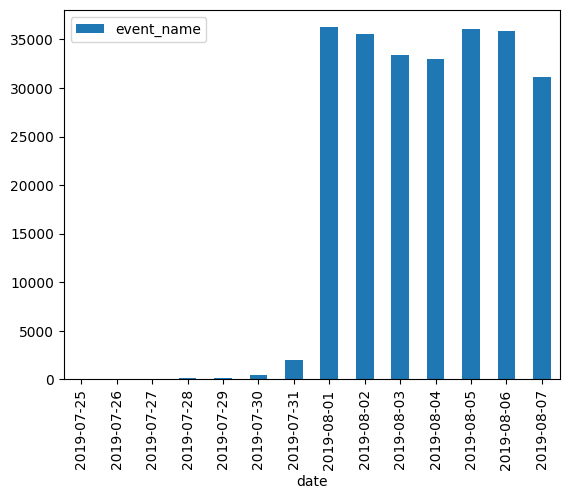

In [5]:
event_unique = logs['event_name'].nunique()
user_nunique = logs['id'].nunique()
avg_event_user = logs.groupby('id').agg({'event_name':['count']}).mean()

print(f'Number of events recorded =',event_unique)
print(f'Number of users in the database =',user_nunique)
print(f'Average events per user =',(float(avg_event_user)))
print(logs['event_time'].min())
print(logs['event_time'].max())

events_by_user = logs.groupby(['date'])['event_name'].count()
events_by_user = events_by_user.to_frame()
events_by_user = events_by_user.reset_index()

print(events_by_user)
events_by_user.plot(kind= 'bar',x='date', y = 'event_name') # I consider the bar graph to be the most efficient for determining the stability period of the data.
plt.show()

# Data Verification 1

We validated the behavior by date to determine the data volume and potential disruptions. We observed that the data behavior appears normal starting from 2019-08-01. The number of recorded events is 5, the average number of events per user is 32.3, and the total number of users in the database is 7,551.

In [6]:
logs_ = logs[logs['event_time'] > '2019-08-01'] # I create a new DF to discard non-relevant data

event_unique_ = logs_['event_name'].nunique() # We perform the same calculations as above to be able to compare and determine if the data we discard may be relevant.
user_nunique_ = logs_['id'].nunique()
avg_event_user_ = logs_.groupby('id').agg({'event_name':['count']}).mean()

unique_group = logs_.groupby('exp_id')['id'].nunique()

print(f'Number of events recorded =',event_unique_)
print(f'Number of users in the database =',user_nunique_)
print(f'Average events per user=',(float(avg_event_user_)))
print(logs_['event_time'].min())
print(logs_['event_time'].max())
print(unique_group)


Numero de eventos registrado = 5
Numero de usuarios en la base de datos = 7534
Promedio de eventos por usuario = 32.02787363950093
2019-08-01 00:07:28
2019-08-07 21:15:17
exp_id
246    2484
247    2513
248    2537
Name: id, dtype: int64


# Data Verification 2

Initially, we applied a filter to our data, discarding all values before the date 2019-08-01. We observed that the information was not significantly altered. The number of recorded events remained the same, and the total number of users decreased by 17, resulting in a new total of 7,517 users. The average number of events per user decreased slightly from 32.3 to 32.02. Upon validating the users by experiment, we found that the three codes contain similar data.

<function matplotlib.pyplot.show(close=None, block=None)>

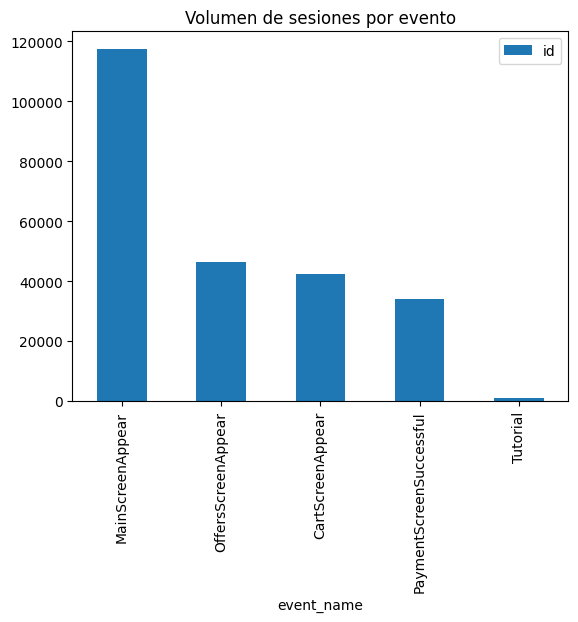

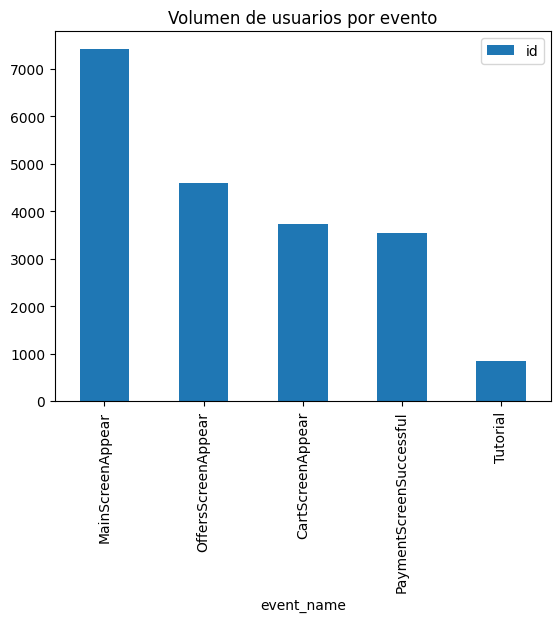

In [7]:
events_sequence = logs_.groupby('event_name').agg({'id':'count'}).sort_values(by = 'id',ascending = False)
unique_sequence = logs_.groupby('event_name').agg({'id':'nunique'}).sort_values(by = 'id',ascending = False)
session_sequence = logs_.pivot_table(index = 'exp_id', columns = 'event_name', values = 'id', aggfunc = 'count')
session_sequence = session_sequence.fillna(0)
session_sequence = session_sequence.reset_index()
session_sequence = session_sequence[['exp_id','MainScreenAppear','Tutorial', 'OffersScreenAppear', 'CartScreenAppear', 'PaymentScreenSuccessful']]


id_sequence = logs_.pivot_table(index = 'exp_id', columns = 'event_name', values = 'id', aggfunc = 'nunique')
id_sequence = id_sequence.fillna(0)
id_sequence = id_sequence.reset_index()
id_sequence = id_sequence[['exp_id','MainScreenAppear','Tutorial', 'OffersScreenAppear', 'CartScreenAppear', 'PaymentScreenSuccessful']]

events_sequence.plot(kind = 'bar', title = 'Volume of sessions per event')
unique_sequence.plot(kind = 'bar', title = 'Volume of users per event')

plt.show

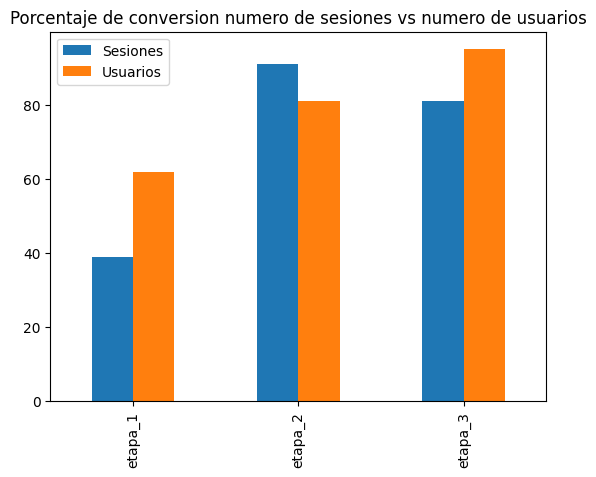

         Sesiones  Usuarios
etapa_1      39.0      62.0
etapa_2      91.0      81.0
etapa_3      81.0      95.0
Numero de usuarios en todas las etapas =  3429


In [8]:
# Funnel analysis by number of sessions, we discard the data for the tutorial, since the number of users seems irrelevant
etapa_1 = ((session_sequence['OffersScreenAppear'].sum())/(session_sequence['MainScreenAppear'].sum())*100).round()
etapa_2 = ((session_sequence['CartScreenAppear'].sum())/(session_sequence['OffersScreenAppear'].sum())*100).round()
etapa_3 = ((session_sequence['PaymentScreenSuccessful'].sum())/(session_sequence['CartScreenAppear'].sum())*100).round()

# Funnel analysis by user

etapa_1_id = ((id_sequence['OffersScreenAppear'].sum())/(id_sequence['MainScreenAppear'].sum())*100).round()
etapa_2_id = ((id_sequence['CartScreenAppear'].sum())/(id_sequence['OffersScreenAppear'].sum())*100).round()
etapa_3_id = ((id_sequence['PaymentScreenSuccessful'].sum())/(id_sequence['CartScreenAppear'].sum())*100).round()

# Users at all stages

usuarios_etapas = logs_.pivot_table(index = 'id', columns = 'event_name', values = 'date', aggfunc = 'count')
usuarios_etapas = usuarios_etapas.fillna(0)
usuarios_etapas = usuarios_etapas.reset_index()
id_filtro_1 = usuarios_etapas[(usuarios_etapas['MainScreenAppear'] != 0)&(usuarios_etapas['OffersScreenAppear'] != 0)&(usuarios_etapas['CartScreenAppear'] != 0)&(usuarios_etapas['PaymentScreenSuccessful'] != 0)]
user_all_stages = id_filtro_1['id'].count()

data = {'Sesiones': [etapa_1, etapa_2, etapa_3], 'Usuarios': [etapa_1_id, etapa_2_id, etapa_3_id]}

conversion = pd.DataFrame(data = data, index = ['etapa_1', 'etapa_2', 'etapa_3'])

conversion.plot(kind = 'bar', title = 'Conversion rate number of sessions and number of users')

plt.show()
print(conversion)
print(f'Number of users in all stages = ',user_all_stages)

# Event Analysis

In the first part of the analysis, I compared the volume of sessions and the number of users per event. While the volumes are different, the behavior is similar for both. We established an order that will guide us through the evaluation of the stages. "MainScreenAppear" is the most popular event, where most users tend to stay, while "Tutorial" is the least important event and is quite irrelevant. It’s difficult to understand the role of the "Tutorial" within the user funnel.

Thanks to this initial analysis, we were able to define the stages of the funnel, which are as follows:

Stage 1: MainScreenAppear to OffersScreenAppear
Stage 2: OffersScreenAppear to CartScreenAppear
Stage 3: CartScreenAppear to PaymentScreenSuccessful
Additionally, we compared the number of sessions and the number of users, showing similar trends but different percentages. Stage 1 has the lowest conversion rate in both scenarios, but the percentage of users is higher than the number of sessions, suggesting that some users need multiple sessions before progressing to the next event. In Stage 2, we noticed a higher percentage of sessions than users, indicating that some users pass through this stage more than once. For Stage 3, which determines the user’s purchase, we observed a higher conversion rate among users, suggesting that some may need more than one visit to their shopping cart before completing the purchase.

Finally, we calculated the number of users who passed through all the stages, which amounted to 3,429 users, representing 45% of the total users who entered the homepage.


In [9]:
# A/A testing starts
# I will make conversion rates for each user based on the previously described stages, so we can make a statistical comparison between experiment groups.
session_by_user = logs_.pivot_table(index = 'id', columns = 'event_name', values = 'event_time', aggfunc = 'count')
session_by_user = session_by_user.fillna(0)
session_by_user = session_by_user.reset_index()

exp_list = (logs_[['id','exp_id']]).drop_duplicates()

exp_session = session_by_user.merge(exp_list, on = 'id') # I make a new data frame that contains the information on sessions per user and which experiment group they belong to.
exp_session = exp_session[['id','exp_id','MainScreenAppear', 'OffersScreenAppear', 'CartScreenAppear', 'PaymentScreenSuccessful', 'Tutorial']] # I reorder the columns according to the funnel proposed above, we leave the tutorial column at the end, since it is outside the stages

print(user_by_group)
print(exp_session)

exp_id
246    2484
247    2513
248    2537
Name: id, dtype: int64
                       id  exp_id  MainScreenAppear  OffersScreenAppear  \
0        6888746892508752     246               1.0                 0.0   
1        6909561520679493     247               2.0                 1.0   
2        6922444491712477     246              19.0                12.0   
3        7435777799948366     248               6.0                 0.0   
4        7702139951469979     247              40.0                87.0   
...                   ...     ...               ...                 ...   
7529  9217594193087726423     246               0.0                 3.0   
7530  9219463515465815368     248              11.0                 4.0   
7531  9220879493065341500     246               4.0                 1.0   
7532  9221926045299980007     246               7.0                 0.0   
7533  9222603179720523844     248              59.0                 0.0   

      CartScreenAppear  PaymentSc

In [10]:
# Calculation of conversion percentage for each stage

exp_session['etapa_1'] = ((exp_session['OffersScreenAppear']/exp_session['MainScreenAppear'])*100).round()
exp_session['etapa_2'] = ((exp_session['CartScreenAppear']/exp_session['OffersScreenAppear'])*100).round()
exp_session['etapa_3'] = ((exp_session['PaymentScreenSuccessful']/exp_session['CartScreenAppear'])*100).round()

exp_session = exp_session.fillna(0)
exp_session['etapa_1'] = exp_session['etapa_1'].replace([np.inf], 0) # I use this function to correct those values ​​that are divided by 0, some users do not fully complete the funnel
exp_session['etapa_2'] = exp_session['etapa_2'].replace([np.inf], 0)
exp_session['etapa_3'] = exp_session['etapa_3'].replace([np.inf], 0)
exp_session['total_session'] = exp_session['MainScreenAppear'] + exp_session['OffersScreenAppear'] + exp_session['CartScreenAppear'] + exp_session['PaymentScreenSuccessful'] + exp_session['Tutorial']

print(exp_session)


                       id  exp_id  MainScreenAppear  OffersScreenAppear  \
0        6888746892508752     246               1.0                 0.0   
1        6909561520679493     247               2.0                 1.0   
2        6922444491712477     246              19.0                12.0   
3        7435777799948366     248               6.0                 0.0   
4        7702139951469979     247              40.0                87.0   
...                   ...     ...               ...                 ...   
7529  9217594193087726423     246               0.0                 3.0   
7530  9219463515465815368     248              11.0                 4.0   
7531  9220879493065341500     246               4.0                 1.0   
7532  9221926045299980007     246               7.0                 0.0   
7533  9222603179720523844     248              59.0                 0.0   

      CartScreenAppear  PaymentScreenSuccessful  Tutorial  etapa_1  etapa_2  \
0                  0

In [11]:
# Statistical validation for control groups, test 1 number of sessions
exp_246 = exp_session.query("exp_id == 246")['total_session'].sort_values()
exp_247 = exp_session.query("exp_id == 247")['total_session'].sort_values()

alpha = 0.1

test_1 = st.mannwhitneyu(exp_246, exp_247)

print('p-value:', test_1)

if (test_1.pvalue < alpha):
    print("Null hypothesis rejected: there are significant differences between the distributions of the two groups compared")
else:
    print("The null hypothesis could not be rejected: we cannot draw conclusions about the difference")

p-value: MannwhitneyuResult(statistic=3129241.0, pvalue=0.8738377464685005)
No se pudo rechazar la hipótesis nula: no podemos sacar conclusiones sobre la diferencia


In [12]:
# Statistical validation for control groups, test 2 most popular event MainScreenAppear

exp_246_2 = exp_session.query("exp_id == 246")['MainScreenAppear'].sort_values()
exp_247_2 = exp_session.query("exp_id == 247")['MainScreenAppear'].sort_values()

alpha = 0.1

test_2 = st.mannwhitneyu(exp_246_2, exp_247_2)

print('p-value:', test_2)

if (test_2.pvalue < alpha):
    print("Null hypothesis rejected: there are significant differences between the distributions of the two groups compared")
else:
    print("The null hypothesis could not be rejected: we cannot draw conclusions about the difference")

p-value: MannwhitneyuResult(statistic=3102302.0, pvalue=0.7115215409169378)
No se pudo rechazar la hipótesis nula: no podemos sacar conclusiones sobre la diferencia


In [13]:
# Statistical validation for control groups, test 3 OffersScreenAppear event

exp_246_3 = exp_session.query("exp_id == 246")['OffersScreenAppear'].sort_values()
exp_247_3 = exp_session.query("exp_id == 247")['OffersScreenAppear'].sort_values()

alpha = 0.1

test_3 = st.mannwhitneyu(exp_246_3, exp_247_3)

print('p-value:', test_3)

if (test_3.pvalue < alpha):
    print("Null hypothesis rejected: there are significant differences between the distributions of the two groups compared")
else:
    print("The null hypothesis could not be rejected: we cannot draw conclusions about the difference")

p-value: MannwhitneyuResult(statistic=3176081.0, pvalue=0.2666235086372193)
No se pudo rechazar la hipótesis nula: no podemos sacar conclusiones sobre la diferencia


In [14]:
# Statistical validation for control groups, test 4 CartScreenAppear event

exp_246_4 = exp_session.query("exp_id == 246")['CartScreenAppear'].sort_values()
exp_247_4 = exp_session.query("exp_id == 247")['CartScreenAppear'].sort_values()

alpha = 0.1

test_4 = st.mannwhitneyu(exp_246_4, exp_247_4)

print('p-value:', test_4)

if (test_4.pvalue < alpha):
    print("Null hypothesis rejected: there are significant differences between the distributions of the two groups compared")
else:
    print("The null hypothesis could not be rejected: we cannot draw conclusions about the difference")

p-value: MannwhitneyuResult(statistic=3187544.0, pvalue=0.1638738379820197)
No se pudo rechazar la hipótesis nula: no podemos sacar conclusiones sobre la diferencia


In [15]:
# Statistical validation for control groups, test 5 PaymentScreenSuccessful event

exp_246_5 = exp_session.query("exp_id == 246")['PaymentScreenSuccessful'].sort_values()
exp_247_5 = exp_session.query("exp_id == 247")['PaymentScreenSuccessful'].sort_values()

alpha = 0.1

test_5 = st.mannwhitneyu(exp_246_5, exp_247_5)

print('p-value:', test_5)

if (test_5.pvalue < alpha):
    print("Null hypothesis rejected: there are significant differences between the distributions of the two groups compared")
else:
    print("The null hypothesis could not be rejected: we cannot draw conclusions about the difference")

p-value: MannwhitneyuResult(statistic=3203394.5, pvalue=0.08045883346942552)
Hipótesis nula rechazada: existen diferencias significativas entre las distribuciones de los dos grupos comparados


# A/A Test Analysis

I conducted 5 tests to validate if the control groups were divided correctly, comparing the statistical difference for each event. We started with the overall number of sessions, moved on to the most popular event, and concluded with the least popular event. The first 4 tests passed successfully based on the established standards, but the final test showed a significant difference. Another important point to highlight is the p-value, which decreases with each test, indicating a trend for the data to become more distorted as they move through the funnel. I would affirm that the groups were divided correctly, as 4 out of the 5 tests passed. Clearly, there is a trend for both groups to diverge, but this only becomes apparent in the final phase, where the data becomes more limited.

In [16]:
# Statistical validation for the test group 248, against the control group 247. Test 1 number of sessions
exp_248 = exp_session.query("exp_id == 248")['total_session'].sort_values()
exp_247 = exp_session.query("exp_id == 247")['total_session'].sort_values()

alpha = 0.1

test_cont_1 = st.mannwhitneyu(exp_248, exp_247)

print('p-value:', test_cont_1)

if (test_cont_1.pvalue < alpha):
    print("Null hypothesis rejected: there are significant differences between the distributions of the two groups compared")
else:
    print("The null hypothesis could not be rejected: we cannot draw conclusions about the difference")

p-value: MannwhitneyuResult(statistic=3237592.5, pvalue=0.3357727283211722)
No se pudo rechazar la hipótesis nula: no podemos sacar conclusiones sobre la diferencia


In [17]:
# Statistical validation for the test group 248, against the control group 247. Test 2 MainScreenAppear

exp_248_2 = exp_session.query("exp_id == 248")['MainScreenAppear'].sort_values()
exp_247_2 = exp_session.query("exp_id == 247")['MainScreenAppear'].sort_values()

alpha = 0.1

test_cont_2 = st.mannwhitneyu(exp_248_2, exp_247_2)

print('p-value:', test_cont_2)

if (test_cont_2.pvalue < alpha):
    print("Null hypothesis rejected: there are significant differences between the distributions of the two groups compared")
else:
    print("The null hypothesis could not be rejected: we cannot draw conclusions about the difference")

p-value: MannwhitneyuResult(statistic=3240175.0, pvalue=0.3111301435039656)
No se pudo rechazar la hipótesis nula: no podemos sacar conclusiones sobre la diferencia


In [18]:
# Statistical validation for the test group 248, against the control group 247. Test 3 event OffersScreenAppear

exp_248_3 = exp_session.query("exp_id == 248")['OffersScreenAppear'].sort_values()
exp_247_3 = exp_session.query("exp_id == 247")['OffersScreenAppear'].sort_values()

alpha = 0.1

test_cont_3 = st.mannwhitneyu(exp_248_3, exp_247_3)

print('p-value:', test_cont_3)

if (test_cont_3.pvalue < alpha):
    print("Null hypothesis rejected: there are significant differences between the distributions of the two groups compared")
else:
    print("The null hypothesis could not be rejected: we cannot draw conclusions about the difference")

p-value: MannwhitneyuResult(statistic=3180052.5, pvalue=0.8781267952390089)
No se pudo rechazar la hipótesis nula: no podemos sacar conclusiones sobre la diferencia


In [19]:
# Statistical validation for the test group 248, against the control group 247. Test 4 CartScreenAppear event

exp_248_4 = exp_session.query("exp_id == 248")['CartScreenAppear'].sort_values()
exp_247_4 = exp_session.query("exp_id == 247")['CartScreenAppear'].sort_values()

alpha = 0.1

test_cont_4 = st.mannwhitneyu(exp_248_4, exp_247_4)

print('p-value:', test_cont_4)

if (test_cont_4.pvalue < alpha):
    print("Null hypothesis rejected: there are significant differences between the distributions of the two groups compared")
else:
    print("The null hypothesis could not be rejected: we cannot draw conclusions about the difference")

p-value: MannwhitneyuResult(statistic=3206149.0, pvalue=0.7025025502285716)
No se pudo rechazar la hipótesis nula: no podemos sacar conclusiones sobre la diferencia


In [20]:
# Statistical validation for the test group 248, against the control group 247. Test 5 PaymentScreenSuccessful event
exp_248_5 = exp_session.query("exp_id == 248")['PaymentScreenSuccessful'].sort_values()
exp_247_5 = exp_session.query("exp_id == 247")['PaymentScreenSuccessful'].sort_values()

alpha = 0.1

test_cont_5 = st.mannwhitneyu(exp_248_5, exp_247_5)

print('p-value:', test_cont_5)

if (test_cont_5.pvalue < alpha):
    print("Null hypothesis rejected: there are significant differences between the distributions of the two groups compared")
else:
    print("The null hypothesis could not be rejected: we cannot draw conclusions about the difference")

p-value: MannwhitneyuResult(statistic=3223808.0, pvalue=0.4485941318325527)
No se pudo rechazar la hipótesis nula: no podemos sacar conclusiones sobre la diferencia


# A/B Analysis: Test Group 248 vs Control Group 247

Initially, for the A/B analysis, we selected Group 247, as it showed a better proportion compared to Control Group 248. In the 5 tests conducted, we found no statistically significant differences, unlike the control analysis, which presented some differences between groups.

The A/B analysis reveals a trend in the p-value, which is far from the alpha value. The comparison between Groups 248 and 247 appears effective and shows significant differences at each event.

In conclusion, we determined that the changes made to the platform do not affect user behavior. The test group and the control group exhibited very similar behavior, providing confidence to proceed with the changes.